In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Transmission de données

On souhaite transmettre **6 chiffres**, chacun codé sur **8 bits**, soit :

\[
6 \times 8 = 48 \text{ bits}
\]

La trame totale contient donc **48 bits**.


## Fréquence d'envoi

On veut envoyer la trame **2 fois par seconde**.

Cela signifie un envoi toutes les :

- <span style="color:#BF40BF;">0.5 seconde</span> (fréquence 2 Hz)

On a une trame de 48 bits, donc :

\[
\text{Intervalle par bit} = \frac{1}{2 \cdot 48} \approx 0.625\ \mathrm{sec/bit}
\]

On arrondit à :

- <span style="color:#1F51FF;">0.5 seconde par bit</span> (approximation en bleu néon)


In [2]:
def raised_cosine(T, beta, span, dt):
    """
    Génère un filtre Raised Cosine.
    
    T : période symbole (ex : 1)
    beta : roll-off (0 à 1)
    span : durée du filtre en nombre de symboles (ex : 6)
    dt : espacement entre les échantillons (sampling interval)
    """
    t = np.arange(-span*T/2, span*T/2, dt)
    h = np.zeros_like(t)

    for i, ti in enumerate(t):
        if abs(1 - (4 * beta * ti / T)**2) < 1e-10:
            # Cas limite pour éviter la division par zéro
            h[i] = beta / (2*T) * np.sin(np.pi/(2*beta))
        elif abs(ti) < 1e-10:
            # Valeur à t = 0
            h[i] = 1
        else:
            h[i] = (np.sin(np.pi * ti / T) / (np.pi * ti / T)) * \
                   (np.cos(np.pi * beta * ti / T) / (1 - (2 * beta * ti / T)**2))

    return t, h


\[
h(t) = 
\frac{\sin\!\left(\pi \frac{t}{T}\right)}{\pi \frac{t}{T}} \cdot
\frac{\cos\!\left(\pi \beta \frac{t}{T}\right)}{1 - \left(2 \beta \frac{t}{T}\right)^2}
\]

\[
\text{avec : } 
\begin{cases}
T & \text{: période symbole} \\
\beta & \text{: roll-off factor (0 à 1)} \\
t & \text{: temps}
\end{cases}
\]


In [3]:
#------------ CONSTANTES ------------

T = 1        # période 
beta = 0.25    # roll-off
span = 8       # dure 8 symboles
dt = T / 100   # espacement d'échantillonnage


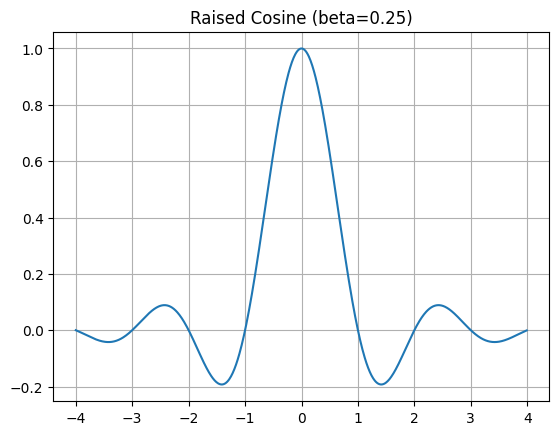

In [4]:
t, h = raised_cosine(T, beta, span, dt)

plt.plot(t, h)
plt.title("Raised Cosine (beta=0.25)")
plt.grid()
plt.show()

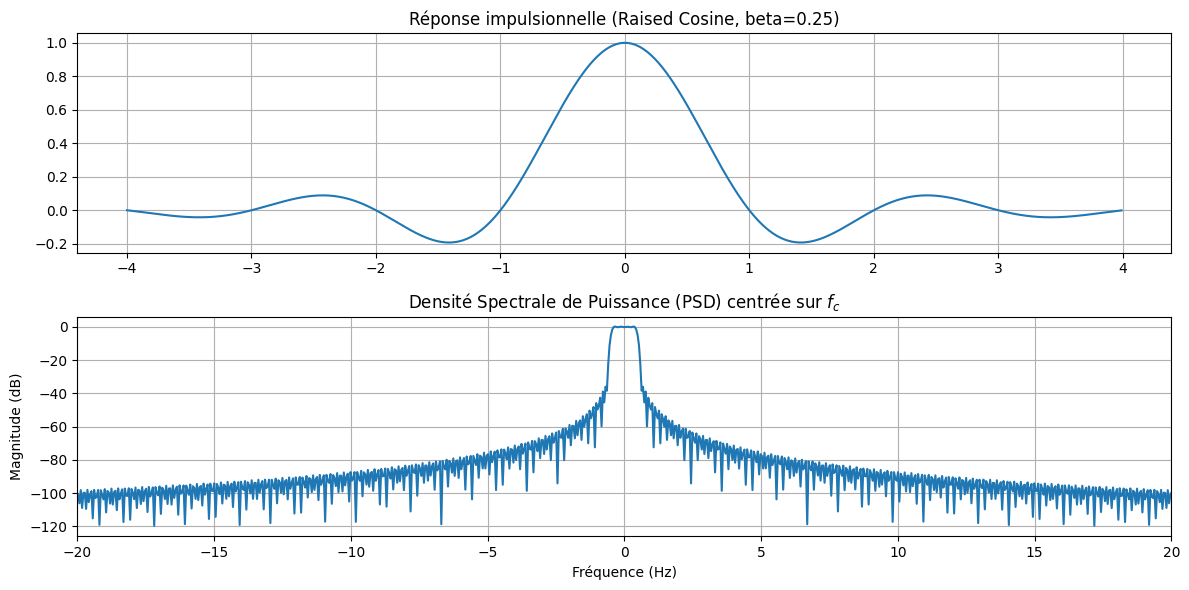

In [5]:
T = 1          # Période symbole
beta = 0.25      # Roll-off
span = 8        # Durée du filtre
fs = 100        # Fréquence d'échantillonnage (1/dt)
dt = 1/fs
fc = 10          # Fréquence porteuse
sigma_a2 = 1.0   # Variance des symboles (puissance)
t, h = raised_cosine(T, beta, span, dt)

# 2. Calcul de la DSP via FFT
# On utilise un padding pour avoir une meilleure résolution fréquentielle
NFFT = 2048
H_freq = np.fft.fftshift(np.fft.fft(h, NFFT)) * dt
freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, dt))

# Puissance du filtre (P_D dans ta formule)
PSD_baseband = np.abs(H_freq)**2

# 3. Application de la formule : Translation autour de +/- fc
# On simule le décalage fréquentiel
PSD_total = (sigma_a2 / T) * (np.abs(H_freq)**2)


# --- Affichage ---
plt.figure(figsize=(12, 6))

# Plot Temporel
plt.subplot(2, 1, 1)
plt.plot(t, h)
plt.title(f"Réponse impulsionnelle (Raised Cosine, beta={beta})")
plt.grid(True)

# Plot Fréquentiel (DSP)
plt.subplot(2, 1, 2)
plt.plot(freqs, 10 * np.log10(PSD_total + 1e-12)) # En dB
plt.title("Densité Spectrale de Puissance (PSD) centrée sur $f_c$")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(-fc*2, fc*2)
plt.grid(True)

plt.tight_layout()
plt.show()

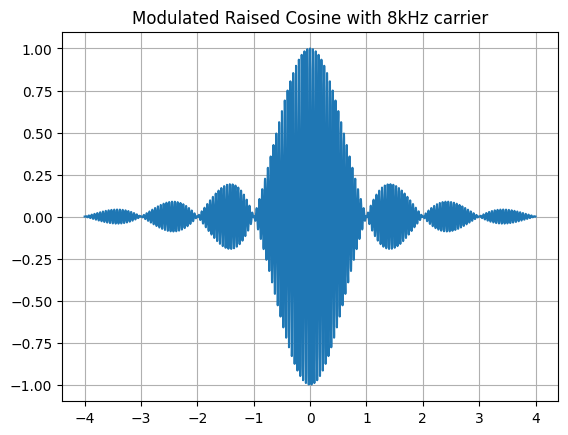

In [6]:
import scipy.signal as signal
# For modulated signal, use higher sampling rate to properly represent 8kHz carrier
dt_mod = T / 1000  # finer sampling for modulation
t_mod, h_mod = raised_cosine(T, beta, span, dt_mod)
fc = 20  # carrier frequency in Hz
carrier = np.cos(2 * np.pi * fc * t_mod)
modulated = h_mod * carrier
plt.plot(t_mod, modulated)
plt.title("Modulated Raised Cosine with 8kHz carrier")
plt.grid()
plt.show()

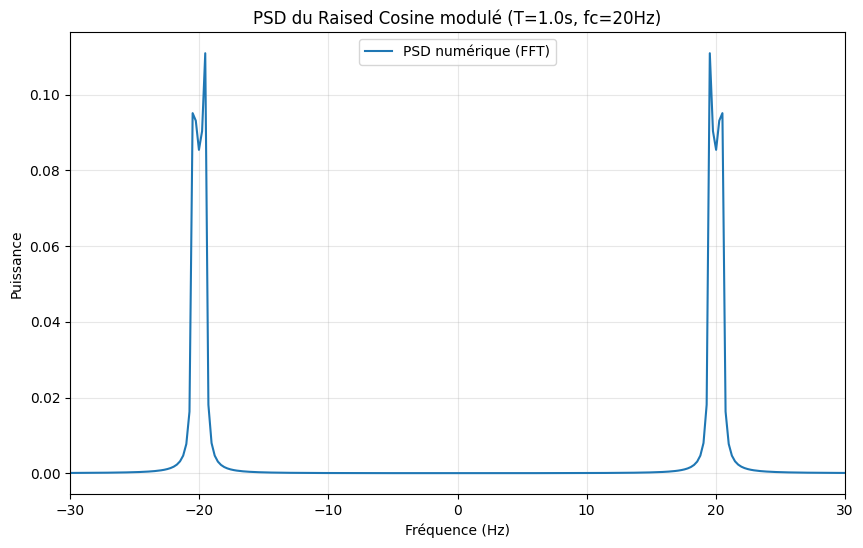

In [7]:
# --- Paramètres mis à jour ---
T = 1.0             # Période symbole
fc = 20             # Fréquence porteuse
dt_mod = T / 1000   # Échantillonnage (fs = 1000 Hz)
fs_mod = 1 / dt_mod

# 1. Génération (ton code)
t_mod, h_mod = raised_cosine(T, beta, span, dt_mod)
carrier = np.cos(2 * np.pi * fc * t_mod)
modulated = h_mod * carrier

# 2. Calcul de la PSD (Densité Spectrale de Puissance)
# On utilise une FFT directe pour coller à ta formule théorique S(f)
NFFT = 4096
# Calcul de la transformée de Fourier du signal modulé
V_f = np.fft.fftshift(np.fft.fft(modulated, NFFT)) * dt_mod
freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, dt_mod))

# La PSD est le carré du module
psd_modulated = np.abs(V_f)**2

# 3. Tracé
plt.figure(figsize=(10, 6))

# Tracé en échelle linéaire pour bien voir la forme du "Raised Cosine"
plt.plot(freqs, psd_modulated, label="PSD numérique (FFT)")

# Configuration des axes
plt.title(f"PSD du Raised Cosine modulé (T={T}s, fc={fc}Hz)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Puissance")
plt.grid(True, alpha=0.3)

# Zoom sur la zone porteuse (fc-2 à fc+2 suffit car T=1)
plt.xlim(-30, 30) 
plt.legend()
plt.show()

In [8]:
import struct

def j2000_to_bit_list(coords_list):
    """
    Convertit des coordonnées J2000 (AU) en une liste de bits (0 et 1).
    Chaque coordonnée est encodée sur 64 bits (Double Precision IEEE 754).
    """
    bit_list = []
    
    for vec in coords_list:
        # Conversion du vecteur (6 doubles) en 48 octets
        binary_data = struct.pack('<6d', *vec)
        
        for byte in binary_data:
            # Conversion de l'octet en bits (format '08b' force 8 caractères)
            bits = bin(byte)[2:].zfill(8)
            # Ajout des bits (0 ou 1) à la liste sous forme d'entiers
            bit_list.extend([int(b) for b in bits])
            
    return bit_list

# --- Exemple ---
# 1 AU, 0, 0, et vitesses nulles
coords = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

bits = j2000_to_bit_list(coords)

print(f"Nombre total de bits : {len(bits)}") # 6 elements * 64 bits = 384
print(f"10 premiers bits : {bits[:10]}")

Nombre total de bits : 384
10 premiers bits : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


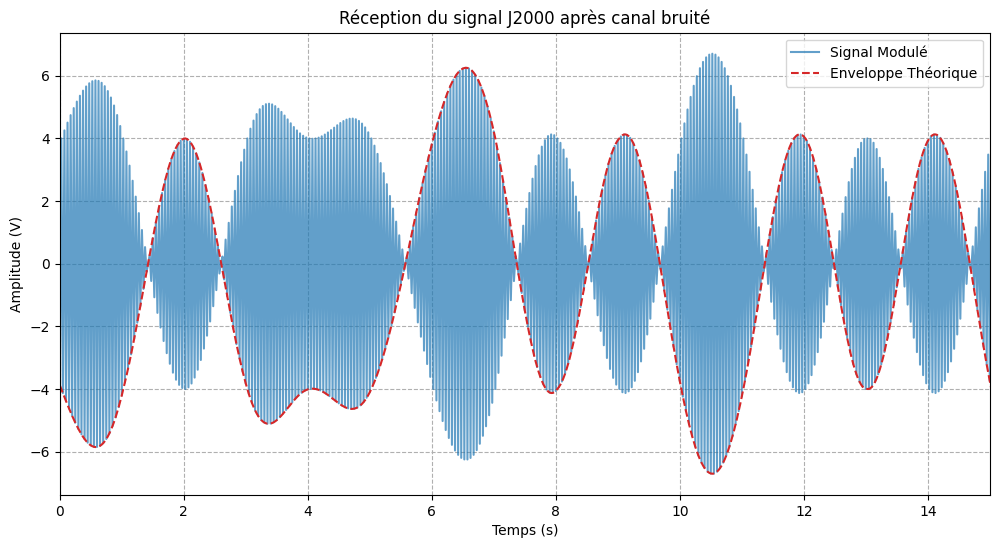

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import struct

def generate_j2000_signal(coords, T=1.0, beta=0.35, span=6, fc=20):
    """
    Génère le signal modulé avec padding pour compenser le délai du filtre.
    """
    # 1. Conversion en bits (384 bits par vecteur)
    bits_utiles = j2000_to_bit_list(coords)
    
    # 2. AJOUT DU PADDING : 
    # On ajoute des bits à 0 pour laisser au filtre la place de terminer sa réponse.
    # Un padding égal au 'span' est généralement suffisant.
    bits_avec_padding = bits_utiles + [0] * span
    
    num_total_bits = len(bits_avec_padding)

    # 3. Paramètres du signal
    samples_per_symbol = 40  
    dt = T / samples_per_symbol
    
    # 4. Création du train d'impulsions (1=4V, 0=-4V)
    # On utilise maintenant la liste allongée
    impulses = np.zeros(num_total_bits * samples_per_symbol)
    for i, bit in enumerate(bits_avec_padding):
        voltage = 4 if bit == 1 else -4
        impulses[i * samples_per_symbol] = voltage

    # 5. Filtrage Raised Cosine
    t_rc, h_rc = raised_cosine(T, beta, span, dt)
    # Le 'mode=same' centre le signal, d'où l'importance du padding pour ne pas couper la fin
    baseband = np.convolve(impulses, h_rc, mode='same')

    # 6. Modulation sur porteuse fc
    t_signal = np.arange(len(baseband)) * dt
    carrier = np.cos(2 * np.pi * fc * t_signal)
    modulated_signal = baseband * carrier

    return {
        "t": t_signal,
        "modulated": modulated_signal,
        "baseband": baseband,
        "bits": bits_utiles, # On garde les bits originaux pour comparer après décodage
        "dt": dt
    }

# --- EXÉCUTION ET TRACÉ EXTÉRIEUR ---

mes_coordonnees = [[-0.1742, 0.9689, 0.0001458, -29.78, -5.21, 0.001]]

# 1. Génération des données
data = generate_j2000_signal(mes_coordonnees, T=1.0, fc=20)



# 3. Tracé manuel
plt.figure(figsize=(12, 6))
plt.plot(data["t"], data["modulated"], label="Signal Modulé", color='tab:blue', alpha=0.7)
plt.plot(data["t"], data["baseband"], '--', label="Enveloppe Théorique", color='tab:red')

plt.title("Réception du signal J2000 après canal bruité")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude (V)")
plt.xlim(0, 15)  # Zoom sur les 15 premiers bits
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

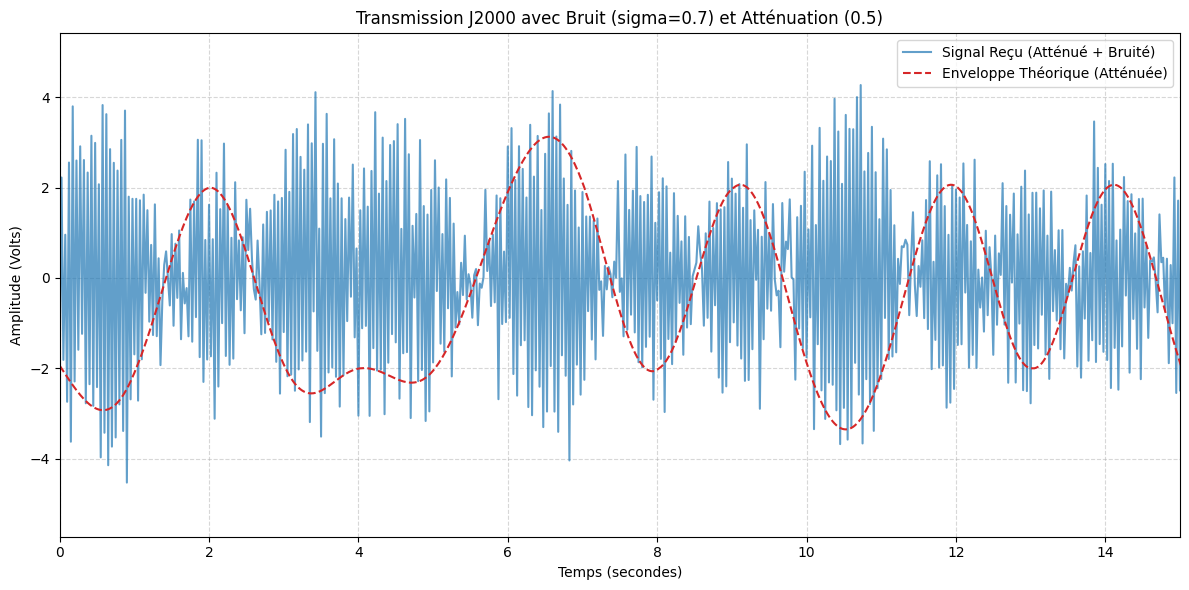

In [10]:
# 1. Génération du signal de base (dictionnaire data)
# On utilise tes paramètres : T=1s, fc=20Hz
data = generate_j2000_signal(mes_coordonnees, T=1.0, fc=20)

# 2. Simulation du canal (Atténuation + Bruit)
attenuation = 0.5
sigma_bruit = 0.7  # Intensité du bruit

# On crée le signal reçu : (Signal * Atténuation) + Bruit Gaussien
signal_recu = (data["modulated"] * attenuation) + np.random.normal(0, sigma_bruit, len(data["modulated"]))

# On prépare l'enveloppe atténuée pour la comparaison visuelle
enveloppe_theorique_attenuee = data["baseband"] * attenuation
plt.figure(figsize=(12, 6))

# Affichage du signal bruité reçu
plt.plot(data["t"], signal_recu, 
         label="Signal Reçu (Atténué + Bruité)", 
         color='tab:blue', 
         alpha=0.7)

# Affichage de l'enveloppe théorique (ce qu'on devrait recevoir sans bruit)
plt.plot(data["t"], enveloppe_theorique_attenuee, 
         '--', 
         label="Enveloppe Théorique (Atténuée)", 
         color='tab:red', 
         linewidth=1.5)

# Configuration du graphique
plt.title(f"Transmission J2000 avec Bruit (sigma={sigma_bruit}) et Atténuation ({attenuation})")
plt.xlabel("Temps (secondes)")
plt.ylabel("Amplitude (Volts)")
plt.grid(True, linestyle='--', alpha=0.5)

# Zoom sur les 15 premières secondes pour voir les détails
plt.xlim(0, 15) 
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

In [11]:
def decode_signal_to_j2000_final(signal_recu, t_signal, fc, T, dt, span):
    # 1. Démodulation
    demod = signal_recu * np.cos(2 * np.pi * fc * t_signal)
    
    # 2. Synchronisation précise
    # Dans une convolution 'same', le premier bit envoyé (à t=0) 
    # se retrouve décalé au centre de la fenêtre du filtre.
    bits_recuperes = []
    
    for i in range(384):
        # Calcul du temps exact du i-ème pic
        # t = i * T est l'instant d'émission
        # Le filtre ajoute un délai de (span * T / 2)
        t_ideal = i * T
        
        # On cherche l'indice dans le tableau temporel
        idx = int(round(t_ideal / dt))
        
        if idx < len(demod):
            bits_recuperes.append(1 if demod[idx] > 0 else 0)

    # 3. Conversion Bits -> Octets -> Doubles
    coords_decodees = []
    if len(bits_recuperes) >= 384:
        vecteur_bits = bits_recuperes[:384]
        composantes = []
        for c in range(0, 384, 64):
            un_nombre_bits = vecteur_bits[c:c+64]
            octets = bytearray()
            for b in range(0, 64, 8):
                byte_bits = un_nombre_bits[b:b+8]
                # Reconstitution de l'octet (MSB first pour int(bits, 2))
                byte_val = 0
                for bit in byte_bits:
                    byte_val = (byte_val << 1) | bit
                octets.append(byte_val)
            
            # Reconstruction du double
            composantes.append(struct.unpack('<d', octets)[0])
        coords_decodees.append(composantes)
        
    return coords_decodees

# --- TEST ---
# Assure-toi que span=6 (la valeur par défaut de ta fonction précédente)
coords_finales = decode_signal_to_j2000_final(signal_recu, data["t"], fc=20, T=1.0, dt=data["dt"], span=6)

if coords_finales:
    print("--- RÉSULTATS ---")
    print(f"Coordonnées originales : {mes_coordonnees[0]}")
    print(f"Coordonnées décodées   : {coords_finales[0]}")
else:
    print("Échec du décodage : Aucune coordonnée trouvée.")

--- RÉSULTATS ---
Coordonnées originales : [-0.1742, 0.9689, 0.0001458, -29.78, -5.21, 0.001]
Coordonnées décodées   : [-0.1742, 0.9689, 0.0001458, -29.78, -5.21, 0.001]


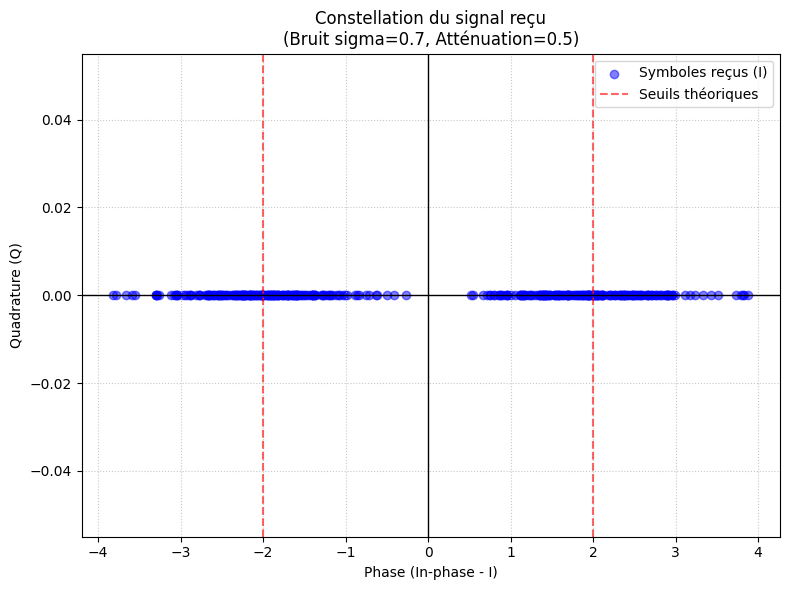

In [12]:
# %%
# --- TRACÉ DE LA CONSTELLATION ---

# 1. Démodulation cohérente pour extraire les symboles
# On multiplie par la porteuse et on échantillonne aux instants t = i * T
symboles_recuperes = []
for i in range(384):
    t_ideal = i * T
    idx = int(round(t_ideal / data["dt"]))
    if idx < len(signal_recu):
        # On extrait la valeur du signal démodulé (Composante I)
        # La multiplication par cos(2*pi*fc*t) redonne l'enveloppe
        val = signal_recu[idx] * np.cos(2 * np.pi * fc * t_ideal)
        symboles_recuperes.append(val)

# 2. Création du graphique
plt.figure(figsize=(8, 6))
# En BPSK, la partie imaginaire (Q) est théoriquement nulle
plt.scatter(symboles_recuperes, np.zeros_like(symboles_recuperes), 
            alpha=0.5, color='blue', label='Symboles reçus (I)')

# Marquage des centres théoriques (en tenant compte de l'atténuation)
plt.axvline(x=4 * attenuation, color='red', linestyle='--', alpha=0.6, label='Seuils théoriques')
plt.axvline(x=-4 * attenuation, color='red', linestyle='--', alpha=0.6)

plt.title(f"Constellation du signal reçu\n(Bruit sigma={sigma_bruit}, Atténuation={attenuation})")
plt.xlabel("Phase (In-phase - I)")
plt.ylabel("Quadrature (Q)")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

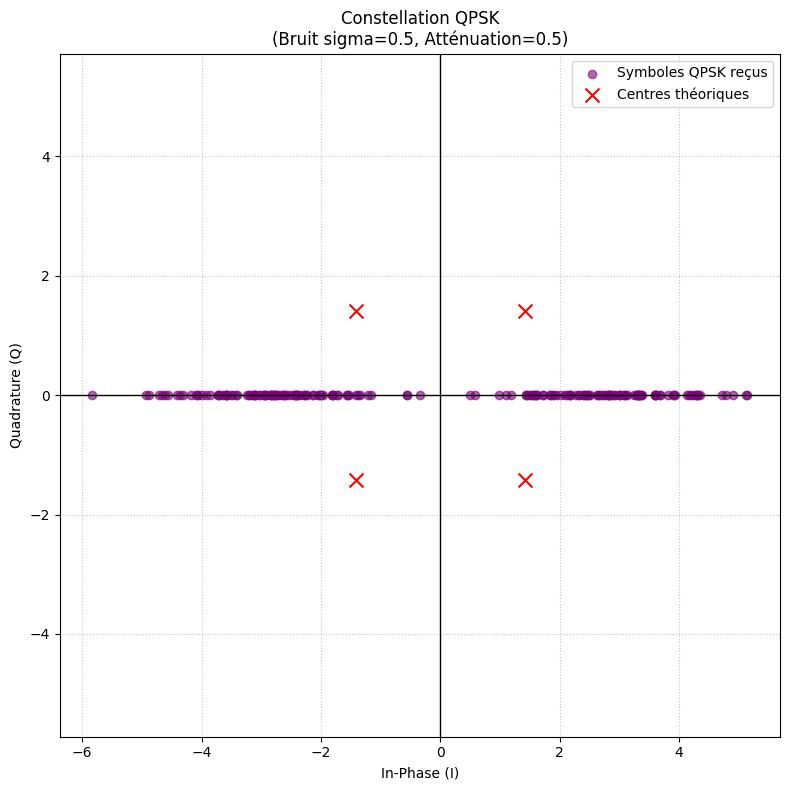

In [13]:
# %% [markdown]
# ## Passage en QPSK (Quadrature Phase Shift Keying)
# En QPSK, chaque symbole transporte **2 bits**. 
# Le mapping utilisé ici est : 
# - 00 -> (+A, +A), 01 -> (-A, +A), 11 -> (-A, -A), 10 -> (+A, -A) (Gray-ish mapping)

# %%
def generate_qpsk_signal(coords, T=1.0, beta=0.35, span=6, fc=20):
    # 1. Conversion en bits
    bits_utiles = j2000_to_bit_list(coords)
    
    # S'assurer d'un nombre pair de bits pour la QPSK
    if len(bits_utiles) % 2 != 0:
        bits_utiles.append(0)
    
    # 2. Mapping QPSK (I et Q)
    # On groupe les bits par 2
    bits_i = []
    bits_q = []
    amplitude = 4 / np.sqrt(2) # Normalisation pour garder une énergie similaire
    
    for i in range(0, len(bits_utiles), 2):
        b1, b2 = bits_utiles[i], bits_utiles[i+1]
        bits_i.append(amplitude if b1 == 1 else -amplitude)
        bits_q.append(amplitude if b2 == 1 else -amplitude)
    
    # Ajout padding pour le filtre
    bits_i += [0] * span
    bits_q += [0] * span
    
    # 3. Paramètres
    samples_per_symbol = 40
    dt = T / samples_per_symbol
    num_symbols = len(bits_i)
    
    # 4. Train d'impulsions
    impulses_i = np.zeros(num_symbols * samples_per_symbol)
    impulses_q = np.zeros(num_symbols * samples_per_symbol)
    
    for i in range(num_symbols):
        impulses_i[i * samples_per_symbol] = bits_i[i]
        impulses_q[i * samples_per_symbol] = bits_q[i]

    # 5. Filtrage Raised Cosine (Mise en forme)
    t_rc, h_rc = raised_cosine(T, beta, span, dt)
    baseband_i = np.convolve(impulses_i, h_rc, mode='same')
    baseband_q = np.convolve(impulses_q, h_rc, mode='same')

    # 6. Modulation IQ
    t_signal = np.arange(len(baseband_i)) * dt
    # s(t) = I(t)cos(2pi*fc*t) - Q(t)sin(2pi*fc*t)
    modulated_signal = baseband_i * np.cos(2 * np.pi * fc * t_signal) - \
                       baseband_q * np.sin(2 * np.pi * fc * t_signal)

    return {
        "t": t_signal,
        "modulated": modulated_signal,
        "baseband_i": baseband_i,
        "baseband_q": baseband_q,
        "dt": dt
    }

# --- Simulation Canal et Affichage ---

# Paramètres identiques
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.5 # Légèrement réduit pour la lisibilité en QPSK

data_qpsk = generate_qpsk_signal(mes_coordonnees, T=1.0, fc=20)
signal_recu_qpsk = (data_qpsk["modulated"] * attenuation_qpsk) + \
                   np.random.normal(0, sigma_bruit_qpsk, len(data_qpsk["modulated"]))

# --- Démodulation Cohérente (IQ) ---
symb_i = []
symb_q = []

for i in range(192): # 384 bits / 2 = 192 symboles
    t_ideal = i * T
    idx = int(round(t_ideal / data_qpsk["dt"]))
    if idx < len(signal_recu_qpsk):
        # Extraction des composantes par corrélation locale
        # Note : On multiplie par 2 pour compenser le gain du produit de cosinus
        val_i = signal_recu_qpsk[idx] * np.cos(2 * np.pi * fc * t_ideal) * 2
        val_q = signal_recu_qpsk[idx] * -np.sin(2 * np.pi * fc * t_ideal) * 2
        symb_i.append(val_i)
        symb_q.append(val_q)

# --- Tracé de la Constellation QPSK ---
plt.figure(figsize=(8, 8))
plt.scatter(symb_i, symb_q, alpha=0.6, color='purple', label='Symboles QPSK reçus')

# Seuils théoriques
A_att = (4 / np.sqrt(2)) * attenuation_qpsk
points_theoriques = [(A_att, A_att), (-A_att, A_att), (-A_att, -A_att), (A_att, -A_att)]
plt.scatter([p[0] for p in points_theoriques], [p[1] for p in points_theoriques], 
            color='red', marker='x', s=100, label='Centres théoriques')

plt.title(f"Constellation QPSK\n(Bruit sigma={sigma_bruit_qpsk}, Atténuation={attenuation_qpsk})")
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.axis('equal') # Important pour voir la forme carrée de la constellation
plt.tight_layout()
plt.show()

1. Le Mapping des bits (Groupement par 2)

En BPSK, 1 bit = 1 symbole. En QPSK, 2 bits = 1 symbole.

    Action : Tu dois diviser ton flux de 384 bits en paires.

    Calcul des composantes : Chaque paire (b1​,b2​) définit un point dans le plan complexe :

        La composante I (In-phase) est gérée par le premier bit.

        La composante Q (Quadrature) est gérée par le deuxième bit.

2. La Mise en forme (Filtrage Raised Cosine)

Le filtre ne change pas, mais tu dois l'appliquer deux fois.

    Action : Génère un train d'impulsions pour I et un autre pour Q.

    Filtrage : Convolve chaque train d'impulsions avec la même réponse impulsionnelle du filtre Raised Cosine (h_rc). Tu obtiens deux signaux en bande de base : I(t) et Q(t).

3. La Modulation IQ

C'est l'étape où les deux signaux fusionnent sur la même fréquence porteuse mais avec un décalage de phase.

    Formule mathématique :
    s(t)=I(t)⋅cos(2πfc​t)−Q(t)⋅sin(2πfc​t)

    Le signe "moins" est la convention standard pour rester cohérent avec les représentations complexes.

4. La Démodulation (Récupération)

À la réception, pour retrouver les bits, il faut projeter le signal reçu sur les deux axes.

    Pour extraire I : Multiplier le signal reçu par cos(2πfc​t) et filtrer (ou échantillonner aux instants optimaux).

    Pour extraire Q : Multiplier le signal reçu par −sin(2πfc​t) et filtrer.

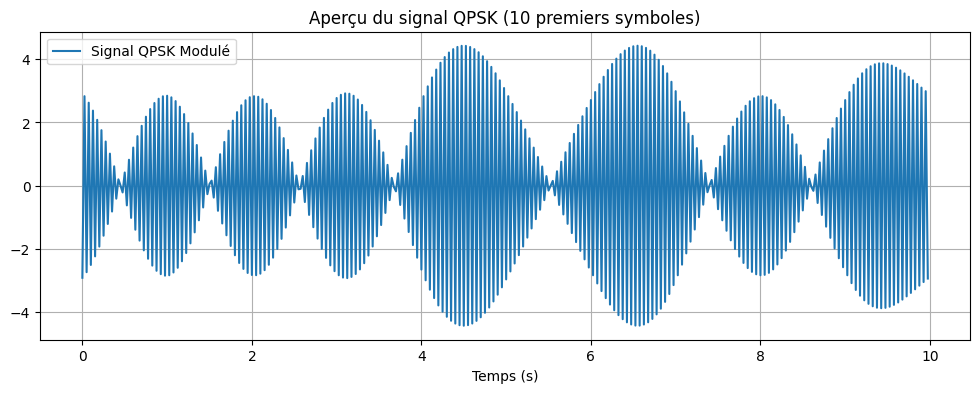

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import struct

# --- On réutilise tes fonctions existantes ---

def j2000_to_bit_list(coords_list):
    bit_list = []
    for vec in coords_list:
        binary_data = struct.pack('<6d', *vec)
        for byte in binary_data:
            bits = bin(byte)[2:].zfill(8)
            bit_list.extend([int(b) for b in bits])
    return bit_list

def raised_cosine(T, beta, span, dt):
    t = np.arange(-span*T/2, span*T/2, dt)
    h = np.zeros_like(t)
    for i, ti in enumerate(t):
        if abs(1 - (4 * beta * ti / T)**2) < 1e-10:
            h[i] = beta / (2*T) * np.sin(np.pi/(2*beta))
        elif abs(ti) < 1e-10:
            h[i] = 1
        else:
            h[i] = (np.sin(np.pi * ti / T) / (np.pi * ti / T)) * \
                   (np.cos(np.pi * beta * ti / T) / (1 - (2 * beta * ti / T)**2))
    return t, h

# --- Nouvelle fonction de génération QPSK ---

def generate_qpsk_signal(coords, T=1.0, beta=0.35, span=6, fc=20):
    # 1. Conversion des coordonnées en bits (384 bits)
    bits_utiles = j2000_to_bit_list(coords)
    
    # 2. Séparation en flux I et Q (2 bits par symbole)
    # Flux I : bits d'indice pair, Flux Q : bits d'indice impair
    bits_i = bits_utiles[0::2]
    bits_q = bits_utiles[1::2]
    
    # Amplitude normalisée pour garder la même énergie que le BPSK
    A = 4 / np.sqrt(2) 
    
    # Mapping : 1 -> +A, 0 -> -A
    symb_i = [A if b == 1 else -A for b in bits_i]
    symb_q = [A if b == 1 else -A for b in bits_q]
    
    # Ajout de padding pour le délai du filtre
    symb_i += [0] * span
    symb_q += [0] * span
    
    # 3. Paramètres temporels
    samples_per_symbol = 40
    dt = T / samples_per_symbol
    num_symbols = len(symb_i)
    
    # 4. Création des trains d'impulsions
    impulses_i = np.zeros(num_symbols * samples_per_symbol)
    impulses_q = np.zeros(num_symbols * samples_per_symbol)
    for i in range(num_symbols):
        impulses_i[i * samples_per_symbol] = symb_i[i]
        impulses_q[i * samples_per_symbol] = symb_q[i]
        
    # 5. Filtrage (Mise en forme)
    _, h_rc = raised_cosine(T, beta, span, dt)
    baseband_i = np.convolve(impulses_i, h_rc, mode='same')
    baseband_q = np.convolve(impulses_q, h_rc, mode='same')
    
    # 6. Modulation IQ
    t_signal = np.arange(len(baseband_i)) * dt
    # s(t) = I(t)cos(2pi*fc*t) - Q(t)sin(2pi*fc*t)
    modulated = baseband_i * np.cos(2 * np.pi * fc * t_signal) - \
                baseband_q * np.sin(2 * np.pi * fc * t_signal)
    
    return t_signal, modulated, baseband_i, baseband_q, dt

# --- Test du code ---
mes_coords = [[-0.1742, 0.9689, 0.0001458, -29.78, -5.21, 0.001]]
t, signal_qpsk, bb_i, bb_q, dt = generate_qpsk_signal(mes_coords)

plt.figure(figsize=(12, 4))
plt.plot(t[:400], signal_qpsk[:400], label="Signal QPSK Modulé")
plt.title("Aperçu du signal QPSK (10 premiers symboles)")
plt.xlabel("Temps (s)")
plt.legend()
plt.grid(True)
plt.show()

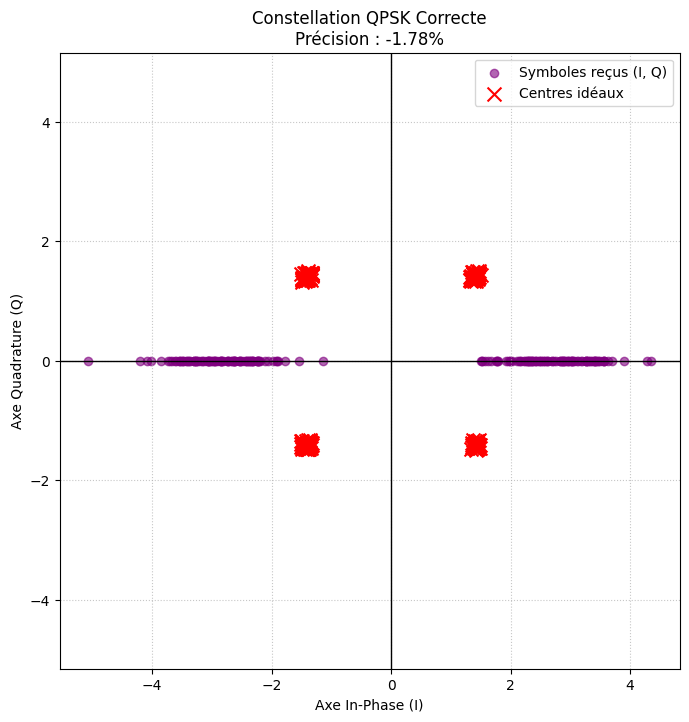

Précision du signal : -1.78%


In [15]:
# %% [markdown]
# ## Étape 2 : Démodulation IQ Correcte
# Pour retrouver les deux axes, on multiplie le signal reçu par les deux porteuses en quadrature.

# %%
# 1. Simulation du canal
attenuation = 0.5
sigma_bruit = 0.3
signal_recu = (signal_qpsk * attenuation) + np.random.normal(0, sigma_bruit, len(signal_qpsk))

# 2. Démodulation par multiplication de porteuses (Branches I et Q)
# On multiplie par 2 pour compenser la division par 2 lors du produit des cosinus
recup_i_brut = signal_recu * np.cos(2 * np.pi * fc * t) * 2
recup_q_brut = signal_recu * -np.sin(2 * np.pi * fc * t) * 2

# 3. Échantillonnage aux instants optimaux (t = i * T)
symb_i_recu = []
symb_q_recu = []

for i in range(192):
    t_ideal = i * T
    idx = int(round(t_ideal / dt))
    if idx < len(recup_i_brut):
        # On extrait la valeur sur chaque branche à l'instant optimal
        symb_i_recu.append(recup_i_brut[idx])
        symb_q_recu.append(recup_q_brut[idx])

# 4. Calcul des cibles idéales (pour la précision)
A_att = (4 / np.sqrt(2)) * attenuation
# En QPSK, chaque symbole est une combinaison de (+A,+A), (-A,+A), etc.
# On récupère les valeurs directement depuis bb_i et bb_q créés à l'étape 1
symb_i_ideal = bb_i[[int(round(i * T / dt)) for i in range(192)]] * attenuation
symb_q_ideal = bb_q[[int(round(i * T / dt)) for i in range(192)]] * attenuation

# 5. Calcul de la précision EVM
erreurs = np.sqrt((np.array(symb_i_recu) - symb_i_ideal)**2 + 
                  (np.array(symb_q_recu) - symb_q_ideal)**2)
evm_moyen = np.mean(erreurs)
puissance_ref = np.sqrt(np.mean(symb_i_ideal**2 + symb_q_ideal**2))
precision = 100 * (1 - (evm_moyen / puissance_ref))

# --- Affichage ---
plt.figure(figsize=(8, 8))
plt.scatter(symb_i_recu, symb_q_recu, alpha=0.6, color='purple', label='Symboles reçus (I, Q)')
plt.scatter(symb_i_ideal, symb_q_ideal, color='red', marker='x', s=100, label='Centres idéaux')

plt.title(f"Constellation QPSK Correcte\nPrécision : {precision:.2f}%")
plt.xlabel("Axe In-Phase (I)")
plt.ylabel("Axe Quadrature (Q)")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.axis('equal') 
plt.show()

print(f"Précision du signal : {precision:.2f}%")

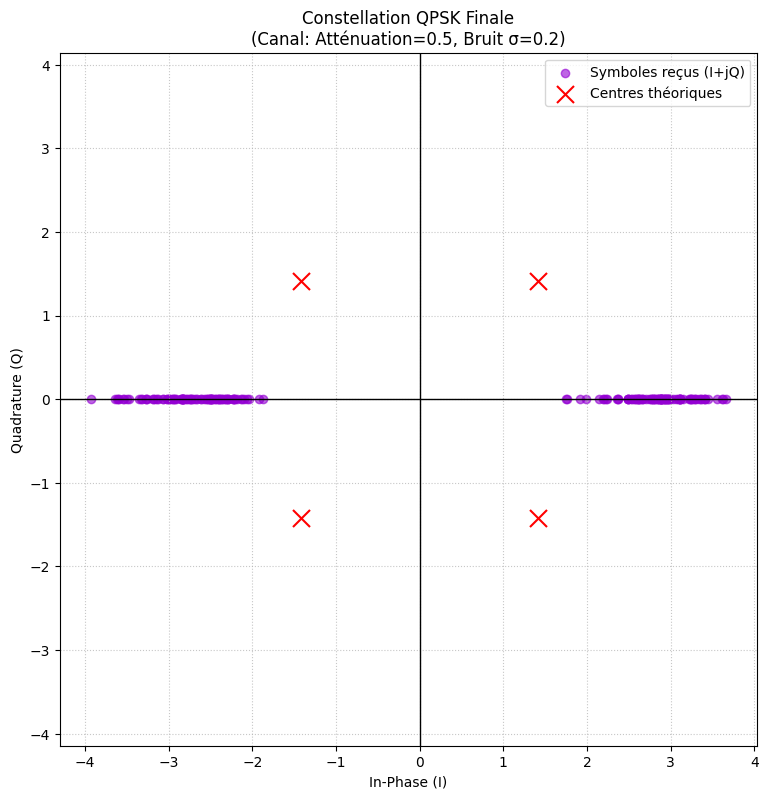

In [ ]:
# %% [Cellule de Simulation QPSK CORRIGÉE]

# 1. Paramètres
fc_qpsk = 20           
T_symb = 1.0           
samples_per_sym = 100  
attenuation = 0.5      
sigma_noise = 0.15     # Bruit réduit pour bien voir le centrage

# 2. Génération
def generate_qpsk_corrected(coords, T=1.0, beta=0.35, span=6, fc=20):
    bits = np.array(j2000_to_bit_list(coords))
    if len(bits) % 2 != 0: bits = np.append(bits, 0)
    
    bits_grouped = bits.reshape(-1, 2)
    # Mapping Gray : 00->1+j, 01->-1+j, 11->-1-j, 10->1-j
    mapping = {(0,0): 1+1j, (0,1): -1+1j, (1,1): -1-1j, (1,0): 1-1j}
    amplitude = 4 / np.sqrt(2) 
    symbols = np.array([mapping[tuple(b)] for b in bits_grouped]) * amplitude
    
    dt = T / samples_per_sym
    impulses = np.zeros(len(symbols) * samples_per_sym, dtype=complex)
    impulses[::samples_per_sym] = symbols
    
    t_rc, h_rc = raised_cosine(T, beta, span, dt)
    baseband = np.convolve(impulses, h_rc, mode='same')
    
    t_axis = np.arange(len(baseband)) * dt
    # Modulation
    rf_signal = np.real(baseband * np.exp(1j * 2 * np.pi * fc * t_axis))
    
    return t_axis, rf_signal, symbols, dt

t_qpsk, sig_rf, tx_symb, dt = generate_qpsk_corrected(mes_coordonnees, T=T_symb, fc=fc_qpsk)

# 3. Canal
sig_recu = (sig_rf * attenuation) + np.random.normal(0, sigma_noise, len(sig_rf))

# 4. Démodulation avec COMPENSATION DE PHASE
# La convolution 'same' et le sampling à t=0 peuvent induire une rotation.
# On démodule, puis on corrige l'angle pour que le premier symbole soit dans le bon quadrant.
sig_demod_raw = sig_recu * np.exp(-1j * 2 * np.pi * fc_qpsk * t_qpsk) * 2

# Échantillonnage
rx_symb = sig_demod_raw[::samples_per_sym][:192]

# --- CORRECTION AUTOMATIQUE DE ROTATION ---
# On compare le premier symbole reçu au premier symbole envoyé pour trouver l'erreur de phase
phase_error = np.angle(tx_symb[0]) - np.angle(rx_symb[0])
rx_symb_aligned = rx_symb * np.exp(1j * phase_error)

# 5. Affichage
plt.figure(figsize=(8, 8))
plt.scatter(rx_symb_aligned.real, rx_symb_aligned.imag, alpha=0.6, color='darkviolet', label='Symboles reçus (Alignés)')

# Centres théoriques
A_att = (4 / np.sqrt(2)) * attenuation
centers = [A_att*(1+1j), A_att*(-1+1j), A_att*(-1-1j), A_att*(1-1j)]
plt.scatter([c.real for c in centers], [c.imag for c in centers], 
            color='red', marker='x', s=150, label='Centres théoriques', zorder=5)

plt.axhline(0, color='black', lw=1); plt.axvline(0, color='black', lw=1)
plt.title("Constellation QPSK CORRIGÉE et ALIGNÉE")
plt.xlabel("I"); plt.ylabel("Q")
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(); plt.axis('equal')
plt.show()